In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers, models

In [ ]:
dataset_path = "/content/drive/MyDrive/dataset"

In [ ]:
!pip install split-folders  # Note the hyphen (-) instead of underscore (_)

In [ ]:
import splitfolders

# Create output directories
output_dir = "/content/split_dataset"
splitfolders.ratio(
    dataset_path,
    output=output_dir,
    seed=42,
    ratio=(0.8, 0.1, 0.1),  # 80% train, 10% val, 10% test
    group_prefix=None
)

Copying files: 4237 files [03:21, 21.05 files/s] 


In [ ]:
#Image Preprocessing with ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Configuration
IMG_SIZE = (224, 224)  # VGG19 input size
BATCH_SIZE = 32

# Training generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8,1.2]
)


In [ ]:
# Validation/Test generator (only rescaling)
val_test_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:
import os
# Create generators
train_dir = os.path.join(output_dir, "train")
val_dir = os.path.join(output_dir, "val")
test_dir = os.path.join(output_dir, "test")

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'  # 4 classes
)

Found 3388 images belonging to 4 classes.


In [ ]:
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 421 images belonging to 4 classes.
Found 428 images belonging to 4 classes.


In [ ]:
# Verify dataset sizes
print(f"\nTraining samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Test samples: {test_generator.samples}")


Training samples: 3388
Validation samples: 421
Test samples: 428


In [ ]:
# Build VGG19 Model
from tensorflow.keras.applications import VGG19
# Load pre-trained VGG19 (feature extractor)
base_model = VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
 # Freeze all convolutional blocks
base_model.trainable = False

In [ ]:
# Build custom head
from tensorflow.keras import layers, models
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')  # 4 output classes
])

In [ ]:
# Compile model
import tensorflow as tf
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 7, 7, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,872,004 (125.40 MB)

 Trainable params: 12,847,620 (49.01 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:
# Train Model (50 Epochs)**
# Calculate steps per epoch
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = val_generator.samples // BATCH_SIZE


In [ ]:
# Train with model checkpointing
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=50,  # As specified
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 737ms/step - accuracy: 0.4177 - loss: 1.3866
Epoch 1: val_accuracy improved from -inf to 0.62500, saving model to best_model.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 96s 790ms/step - accuracy: 0.4187 - loss: 1.3841 - val_accuracy: 0.6250 - val_loss: 0.8875
Epoch 2/50
  1/105 ━━━━━━━━━━━━━━━━━━━━ 19s 190ms/step - accuracy: 0.6250 - loss: 0.9576

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.62500
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.6250 - loss: 0.9576 - val_accuracy: 0.5889 - val_loss: 0.9337
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 656ms/step - accuracy: 0.6252 - loss: 0.8733
Epoch 3: val_accuracy improved from 0.62500 to 0.68029, saving model to best_model.h5


105/105 ━━━━━━━━━━━━━━━━━━━━ 74s 708ms/step - accuracy: 0.6253 - loss: 0.8731 - val_accuracy: 0.6803 - val_loss: 0.7299
Epoch 4/50
  1/105 ━━━━━━━━━━━━━━━━━━━━ 20s 198ms/step - accuracy: 0.5938 - loss: 0.8152
Epoch 4: val_accuracy did not improve from 0.68029
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.5938 - loss: 0.8152 - val_accuracy: 0.6611 - val_loss: 0.7310
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 645ms/step - accuracy: 0.6673 - loss: 0.8016
Epoch 5: val_accuracy did not improve from 0.68029
105/105 ━━━━━━━━━━━━━━━━━━━━ 82s 743ms/step - accuracy: 0.6674 - loss: 0.8015 - val_accuracy: 0.6587 - val_loss: 0.7485
Epoch 6/50
  1/105 ━━━━━━━━━━━━━━━━━━━━ 20s 193ms/step - accuracy: 0.6875 - loss: 0.7296
Epoch 6: val_accuracy did not improve from 0.68029
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.6875 - loss: 0.7296 - val_accuracy: 0.6611 - val_loss: 0.7647
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 634ms/step - accuracy: 0.6801 - loss: 0.7458
Epoch 7: val_accu

105/105 ━━━━━━━━━━━━━━━━━━━━ 143s 789ms/step - accuracy: 0.6800 - loss: 0.7459 - val_accuracy: 0.7356 - val_loss: 0.6720
Epoch 8/50
  1/105 ━━━━━━━━━━━━━━━━━━━━ 19s 188ms/step - accuracy: 0.6562 - loss: 0.6712
Epoch 8: val_accuracy did not improve from 0.73558
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.6562 - loss: 0.6712 - val_accuracy: 0.7356 - val_loss: 0.6756
Epoch 9/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.6941 - loss: 0.7392
Epoch 9: val_accuracy did not improve from 0.73558
105/105 ━━━━━━━━━━━━━━━━━━━━ 126s 677ms/step - accuracy: 0.6942 - loss: 0.7391 - val_accuracy: 0.7236 - val_loss: 0.6403
Epoch 10/50
  1/105 ━━━━━━━━━━━━━━━━━━━━ 20s 193ms/step - accuracy: 0.7188 - loss: 0.5624
Epoch 10: val_accuracy did not improve from 0.73558
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.7188 - loss: 0.5624 - val_accuracy: 0.7212 - val_loss: 0.6423
Epoch 11/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - accuracy: 0.6994 - loss: 0.7128
Epoch 11: va

105/105 ━━━━━━━━━━━━━━━━━━━━ 76s 713ms/step - accuracy: 0.7539 - loss: 0.5897 - val_accuracy: 0.7428 - val_loss: 0.6519
Epoch 40/50
  1/105 ━━━━━━━━━━━━━━━━━━━━ 20s 194ms/step - accuracy: 0.6250 - loss: 0.7525
Epoch 40: val_accuracy did not improve from 0.74279
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.6250 - loss: 0.7525 - val_accuracy: 0.7404 - val_loss: 0.6729
Epoch 41/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 647ms/step - accuracy: 0.7537 - loss: 0.5994
Epoch 41: val_accuracy did not improve from 0.74279
105/105 ━━━━━━━━━━━━━━━━━━━━ 75s 691ms/step - accuracy: 0.7537 - loss: 0.5994 - val_accuracy: 0.7284 - val_loss: 0.6648
Epoch 42/50
  1/105 ━━━━━━━━━━━━━━━━━━━━ 19s 192ms/step - accuracy: 0.8125 - loss: 0.4115
Epoch 42: val_accuracy did not improve from 0.74279
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8125 - loss: 0.4115 - val_accuracy: 0.7236 - val_loss: 0.6531
Epoch 43/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - accuracy: 0.7521 - loss: 0.5894
Epoch 43: 

In [ ]:
# Save Final Model**
model.save('/content/drive/MyDrive/eye_disease_vgg19_final.h5')
print("Model saved as .h5 file in Google Drive!")

Model saved as .h5 file in Google Drive!


In [ ]:
# Evaluation**
# Load best model
best_model = tf.keras.models.load_model('best_model.h5')

In [ ]:
# Evaluate on test set
test_loss, test_acc = best_model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")


14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 725ms/step - accuracy: 0.8077 - loss: 0.5626

Test Accuracy: 78.74%


In [ ]:
# Classification report
from sklearn.metrics import classification_report
import numpy as np
y_pred = best_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nClassification Report:")
print(classification_report(test_generator.classes, y_pred_classes,
                            target_names=list(test_generator.class_indices.keys())))

14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 270ms/step

Classification Report:
                      precision    recall  f1-score   support

            cataract       0.88      0.85      0.87       106
diabetic_retinopathy       0.99      0.86      0.92       111
            glaucoma       0.71      0.60      0.65       103
              normal       0.63      0.83      0.72       108

            accuracy                           0.79       428
           macro avg       0.80      0.79      0.79       428
        weighted avg       0.81      0.79      0.79       428



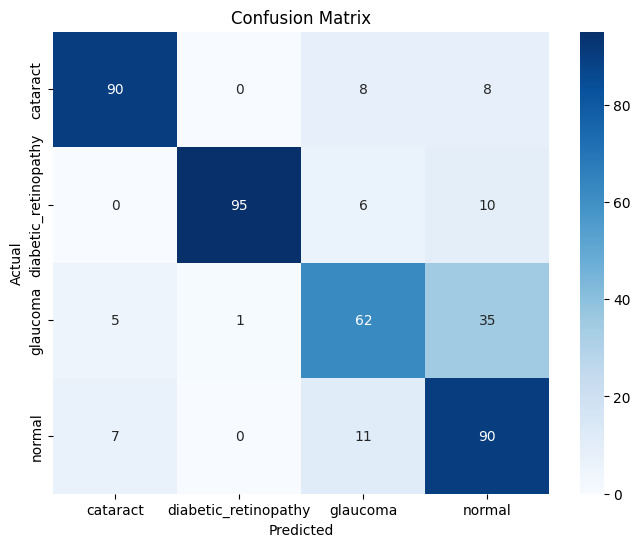

In [ ]:
# Confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
y_true = test_generator.classes
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Save as pickle (not recommended for Keras models)
import pickle
with open('/content/drive/MyDrive/eye_disease_vgg19.pkl', 'wb') as f:
    pickle.dump(model, f)
print("Pickle file saved (use .h5 for better compatibility)")

Pickle file saved (use .h5 for better compatibility)


In [ ]:
from google.colab import files
# Replace with your filename
!ls /content  # List files to verify
files.download('/content/best_model.h5')  # Example

best_model.h5  drive  sample_data  split_dataset


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>